In [1]:
import numpy as np

m, n = (5, 6)  # scalars
M = np.ones((m, n))  # a matrix
v = np.random.random((n,))  # a vector
w = M @ v  # another vector

In [2]:
import numpy as np
A = np.array([[0, 1, 1, 0, 0, 0],
              [1, 0, 1, 0, 0, 0],
              [1, 1, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 1, 1, 0]], dtype=float)

In [3]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

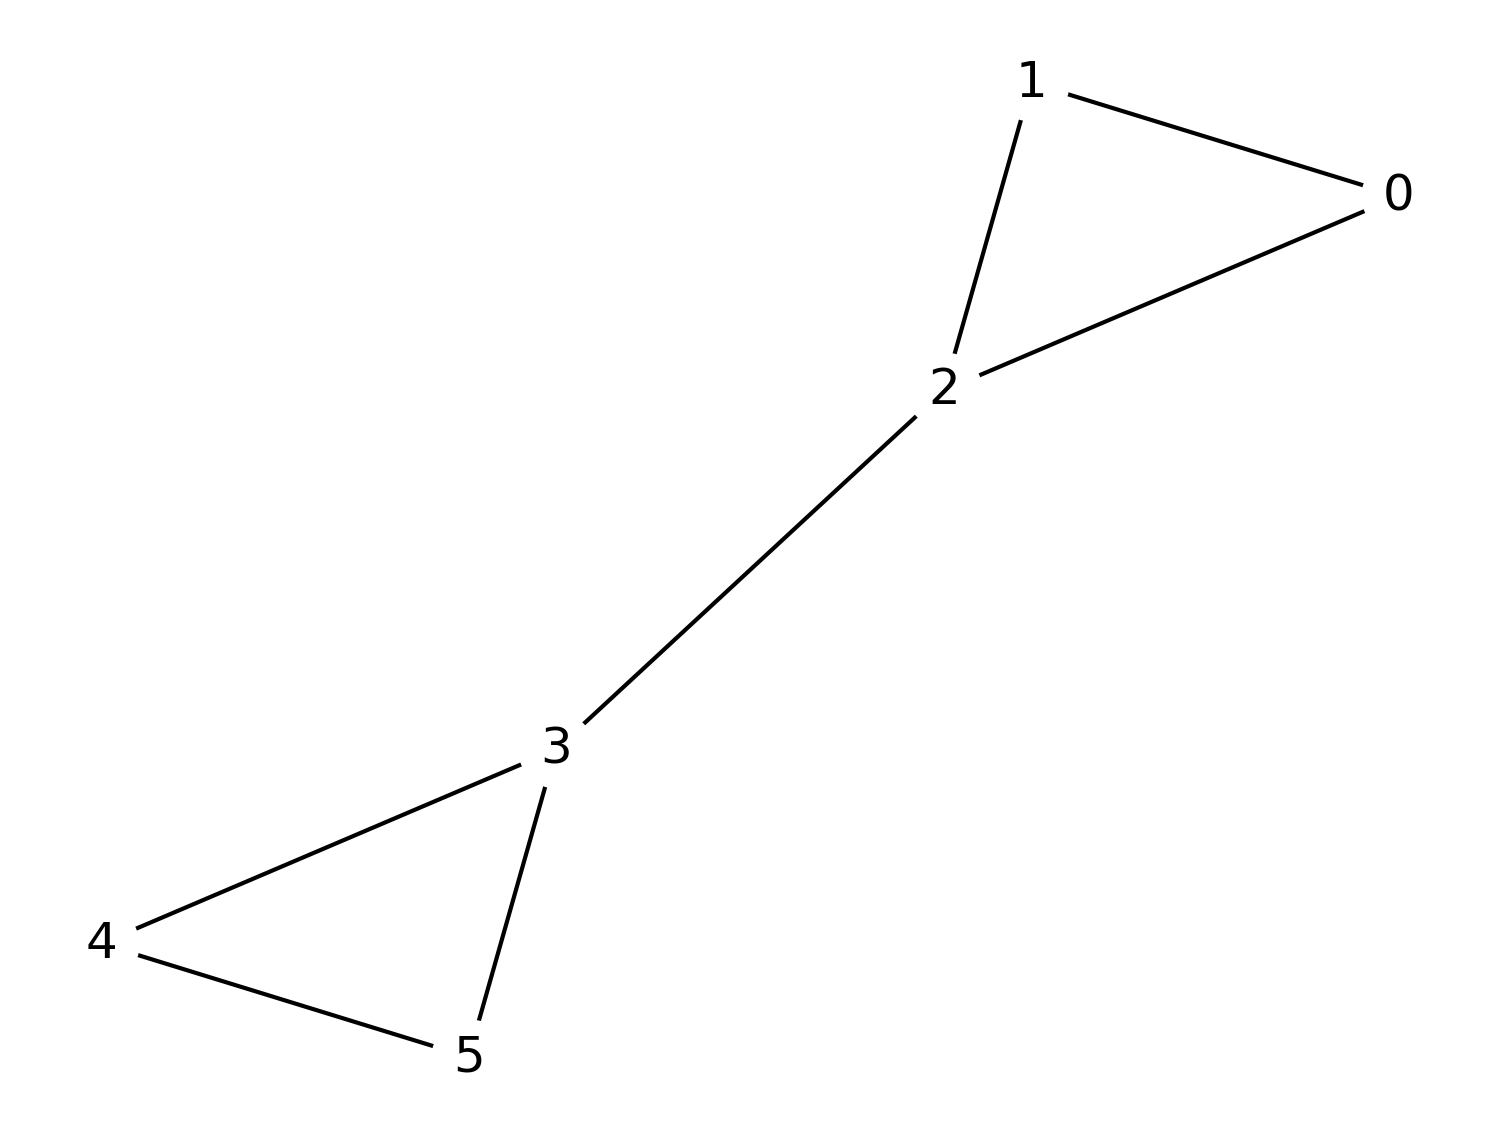

In [4]:
import networkx as nx
g = nx.from_numpy_matrix(A)
layout = nx.spring_layout(g, pos=nx.circular_layout(g))
nx.draw(g, pos=layout,
        with_labels=True, node_color='white')

In [5]:
d = np.sum(A, axis=0)
print(d)

[2. 2. 3. 3. 2. 2.]


In [6]:
D = np.diag(d)
print(D)

[[2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2.]]


In [7]:
L = D - A
print(L)

[[ 2. -1. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.]
 [ 0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1. -1.  2.]]


In [8]:
val, Vec = np.linalg.eigh(L)

In [9]:
np.any(np.isclose(val, 3))

True

In [10]:
idx_lambda3 = np.argmin(np.abs(val - 3))
v3 = Vec[:, idx_lambda3]

print(v3)
print(L @ v3)

[ 0.69255756 -0.51508781 -0.17746975 -0.17746975  0.38564378 -0.20817404]
[ 2.07767267 -1.54526343 -0.53240924 -0.53240924  1.15693135 -0.62452211]


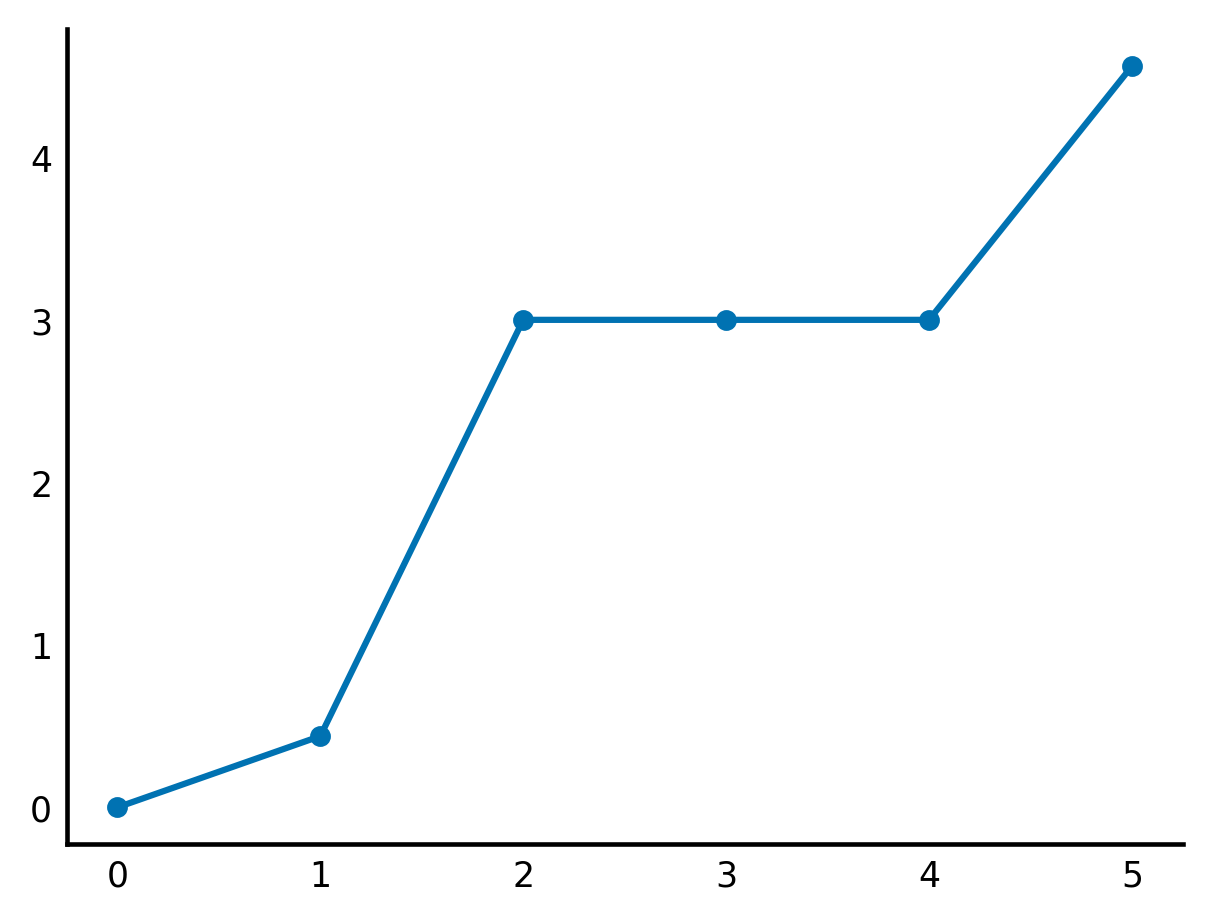

In [11]:
plt.plot(np.sort(val), linestyle='-', marker='o');

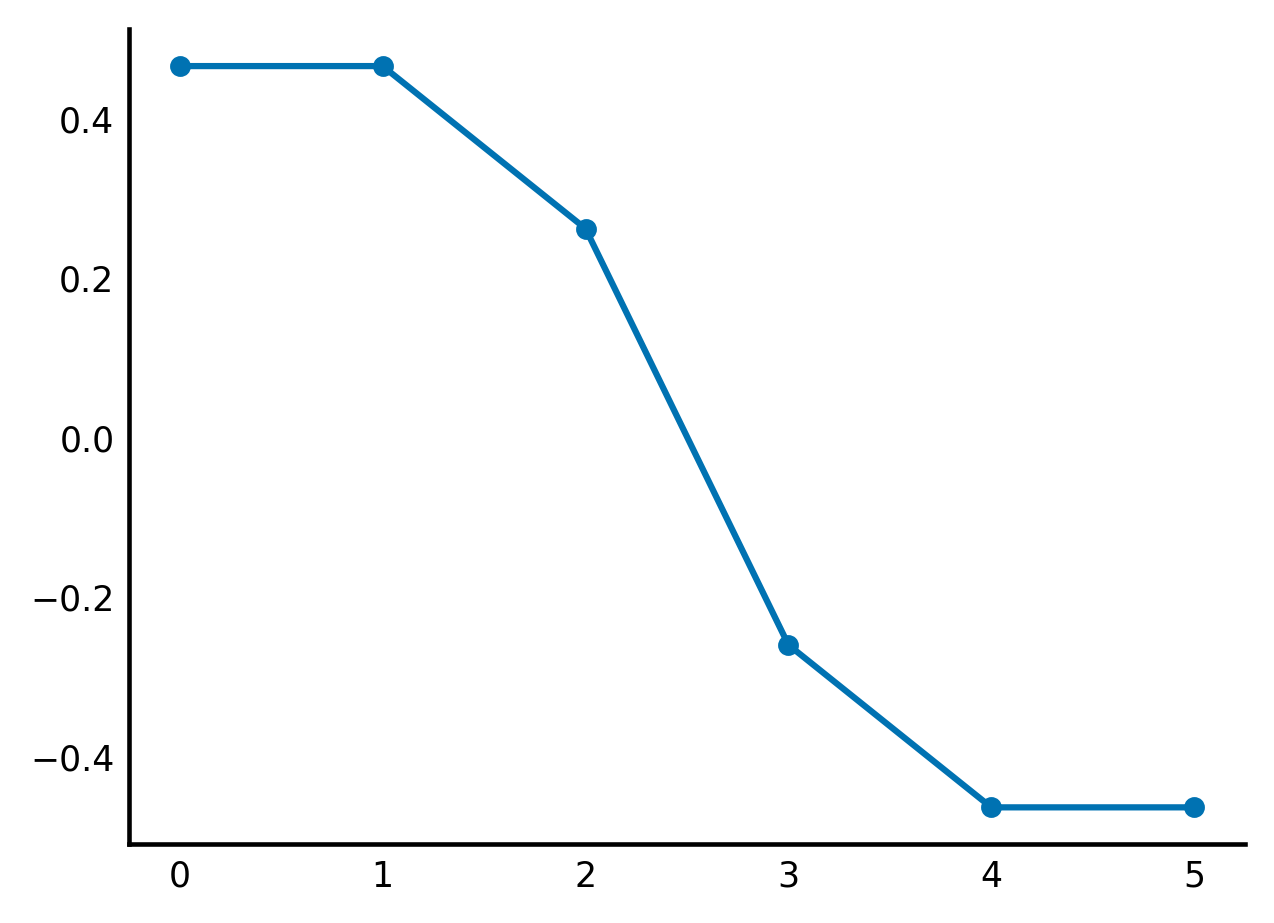

In [12]:
f = Vec[:, np.argsort(val)[1]]
plt.plot(f, linestyle='-', marker='o');

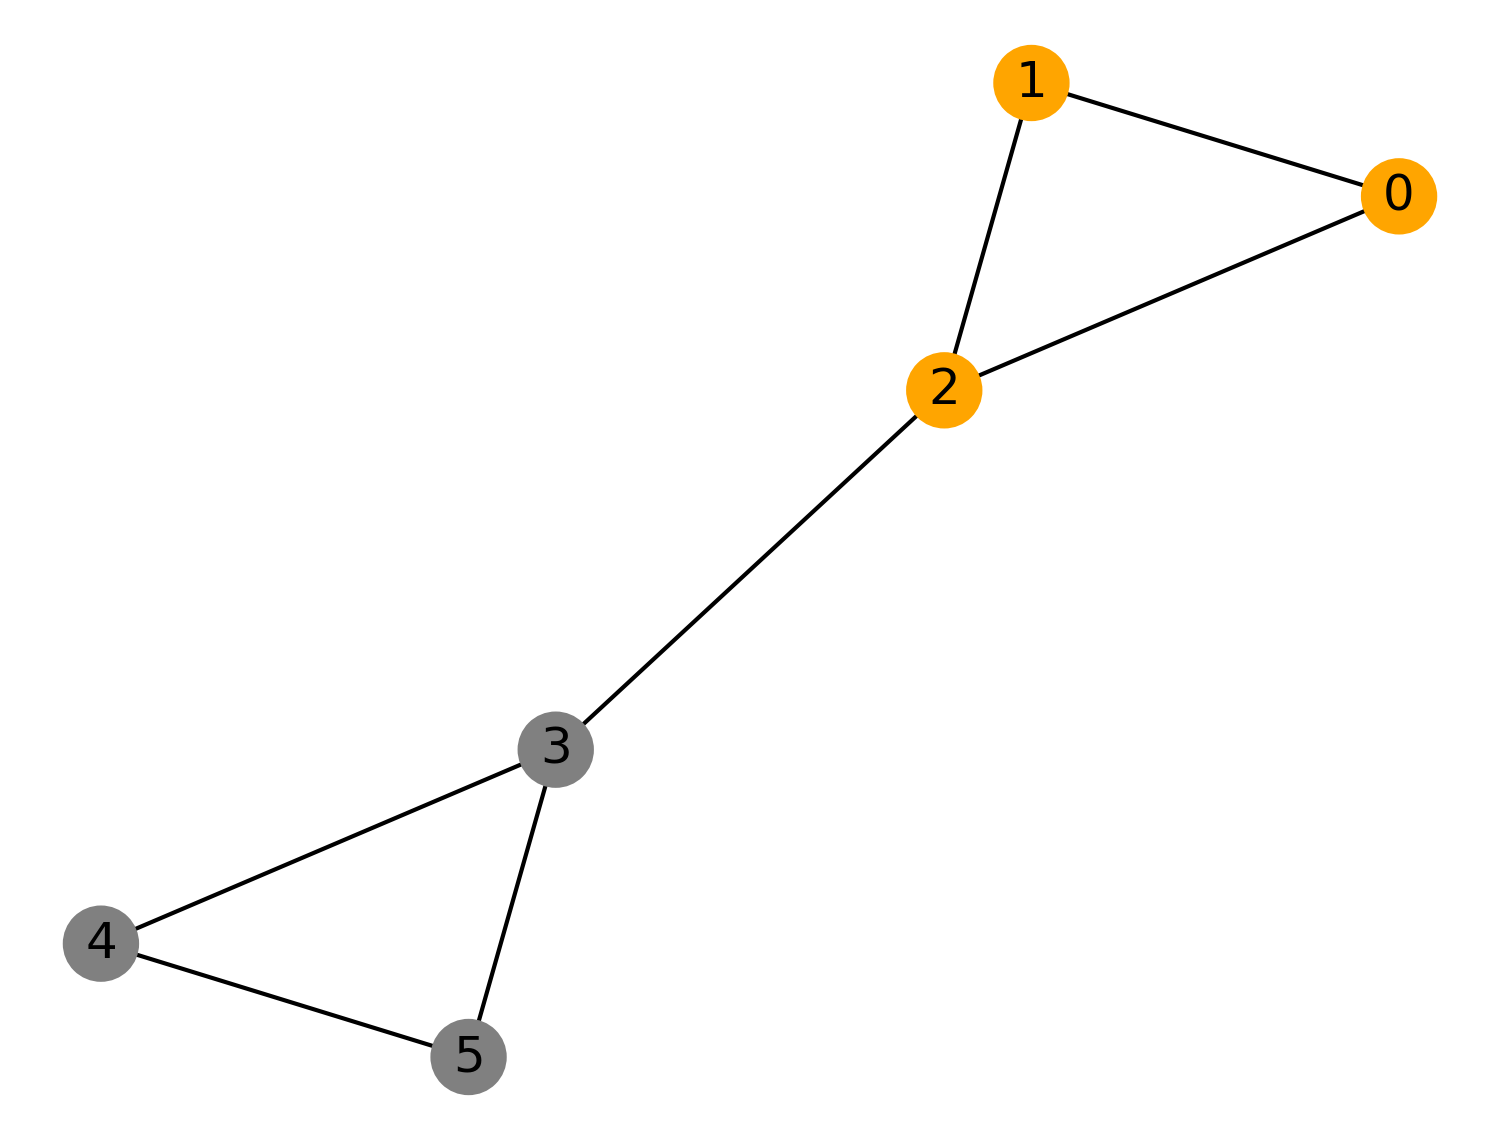

In [13]:
colors = ['orange' if eigv > 0 else 'gray' for eigv in f]
nx.draw(g, pos=layout, with_labels=True, node_color=colors)

In [14]:
import numpy as np
Chem = np.load('../data/chem-network.npy')
Gap = np.load('../data/gap-network.npy')
neuron_ids = np.load('../data/neurons.npy')
neuron_types = np.load('../data/neuron-types.npy')

In [15]:
A = Chem + Gap
C = (A + A.T) / 2

In [16]:
degrees = np.sum(C, axis=0)
D = np.diag(degrees)

In [17]:
L = D - C

In [18]:
from scipy import linalg
b = np.sum(C * np.sign(A - A.T), axis=1)
z = linalg.pinv(L) @ b

In [19]:
Dinv2 = np.diag(1 / np.sqrt(degrees))
Q = Dinv2 @ L @ Dinv2

In [20]:
val, Vec = linalg.eig(Q)

In [21]:
smallest_first = np.argsort(val)
val = val[smallest_first]
Vec = Vec[:, smallest_first]

In [22]:
x = Dinv2 @ Vec[:, 1]

In [23]:
vc2_index = np.argwhere(neuron_ids == 'VC02')
if x[vc2_index] < 0:
    x = -x

In [24]:
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection


def plot_connectome(x_coords, y_coords, conn_matrix, *,
                    labels=(), types=None, type_names=('',),
                    xlabel='', ylabel=''):
    """Plot neurons as points connected by lines.

    Neurons can have different types (up to 6 distinct colors).

    Parameters
    ----------
    x_coords, y_coords : array of float, shape (N,)
        The x-coordinates and y-coordinates of the neurons.
    conn_matrix : array or sparse matrix of float, shape (N, N)
        The connectivity matrix, with nonzero entry (i, j) if and only
        if node i and node j are connected.
    labels : array-like of string, shape (N,), optional
        The names of the nodes.
    types : array of int, shape (N,), optional
        The type (e.g. sensory neuron, interneuron) of each node.
    type_names : array-like of string, optional
        The name of each value of `types`. For example, if a 0 in
        `types` means "sensory neuron", then `type_names[0]` should
        be "sensory neuron".
    xlabel, ylabel : str, optional
        Labels for the axes.
    """
    if types is None:
        types = np.zeros(x_coords.shape, dtype=int)
    ntypes = len(np.unique(types))
    colors = plt.rcParams['axes.prop_cycle'][:ntypes].by_key()['color']
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots()

    # plot neuron locations:
    for neuron_type in range(ntypes):
        plotting = (types == neuron_type)
        pts = ax.scatter(x_coords[plotting], y_coords[plotting],
                         c=cmap(neuron_type), s=4, zorder=1)
        pts.set_label(type_names[neuron_type])
    # add text labels:
    for x, y, label in zip(x_coords, y_coords, labels):
        ax.text(x, y, '   ' + label,
                verticalalignment='center', fontsize=3, zorder=2)

    # plot edges
    pre, post = np.nonzero(conn_matrix)
    links = np.array([[x_coords[pre], x_coords[post]],
                      [y_coords[pre], y_coords[post]]]).T
    ax.add_collection(LineCollection(links, color='lightgray',
                                     lw=0.3, alpha=0.5, zorder=0))

    ax.legend(scatterpoints=3, fontsize=6)

    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)

    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


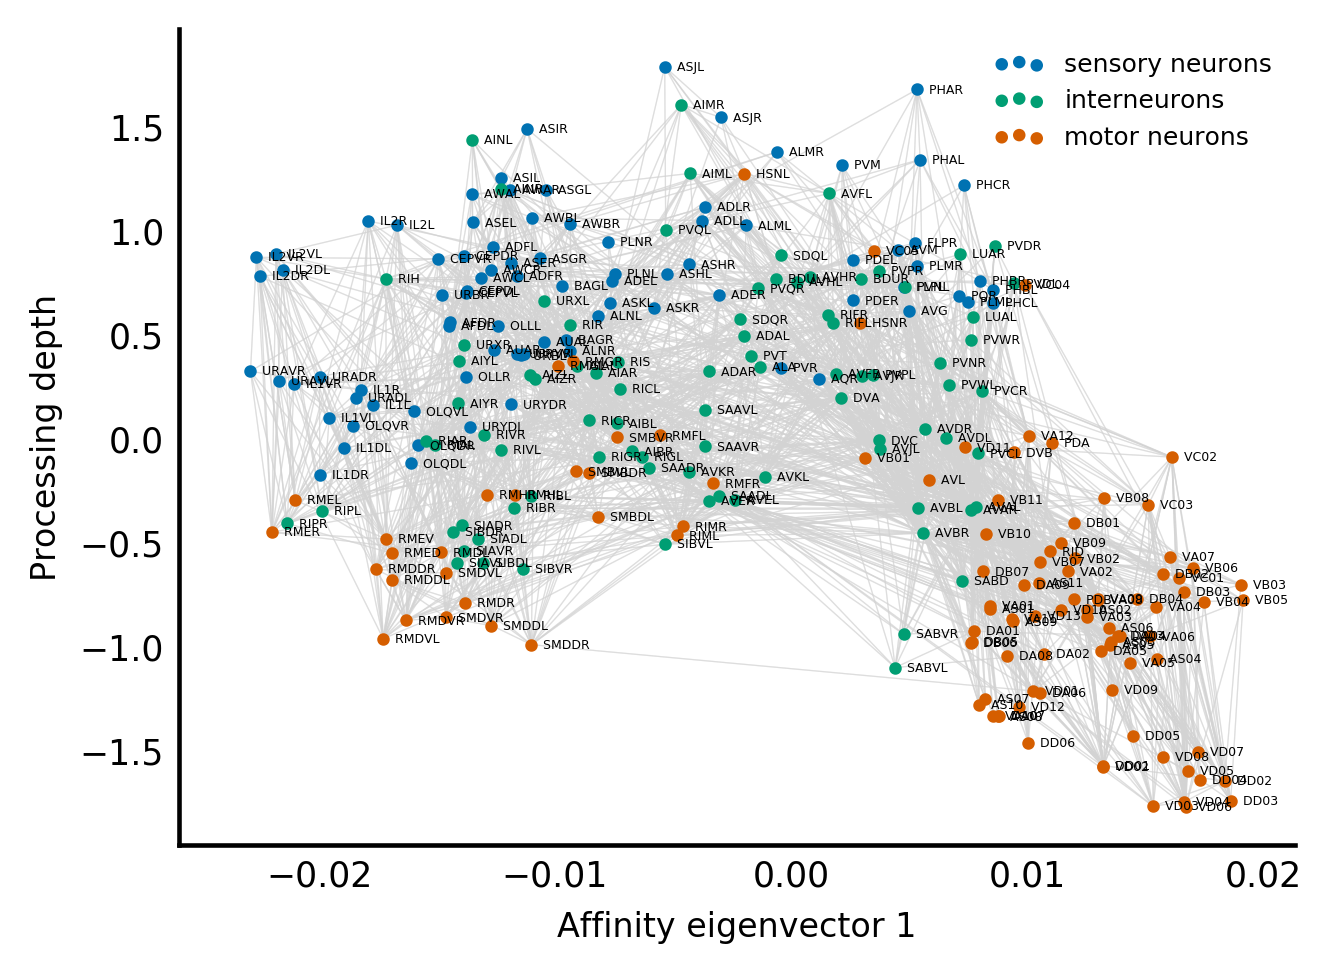

In [25]:
plot_connectome(x, z, C, labels=neuron_ids, types=neuron_types,
                type_names=['sensory neurons', 'interneurons',
                            'motor neurons'],
                xlabel='Affinity eigenvector 1', ylabel='Processing depth')

In [26]:
import networkx as nx

stmarks = nx.read_gml('../data/stmarks.gml')

In [27]:
species = np.array(stmarks.nodes())  # array for multiindexing
Adj = nx.to_scipy_sparse_matrix(stmarks, dtype=np.float64)

In [28]:
n = len(species)

In [29]:
np.seterr(divide='ignore')  # ignore division-by-zero errors
from scipy import sparse

degrees = np.ravel(Adj.sum(axis=1))
Deginv = sparse.diags(1 / degrees).tocsr()

Trans = (Deginv @ Adj).T

In [30]:
from scipy.sparse.linalg import spsolve

damping = 0.85
beta = 1 - damping

I = sparse.eye(n, format='csc')  # Same sparse format as Trans

pagerank = spsolve(I - damping * Trans,
                   np.full(n, beta / n))

In [31]:
def pagerank_plot(in_degrees, pageranks, names, *,
                  annotations=[], **figkwargs):
    """Plot node pagerank against in-degree, with hand-picked node names."""

    fig, ax = plt.subplots(**figkwargs)
    ax.scatter(in_degrees, pageranks, c=[0.835, 0.369, 0], lw=0)
    for name, indeg, pr in zip(names, in_degrees, pageranks):
        if name in annotations:
            text = ax.text(indeg + 0.1, pr, name)

    ax.set_ylim(0, np.max(pageranks) * 1.1)
    ax.set_xlim(-1, np.max(in_degrees) * 1.1)
    ax.set_ylabel('PageRank')
    ax.set_xlabel('In-degree')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


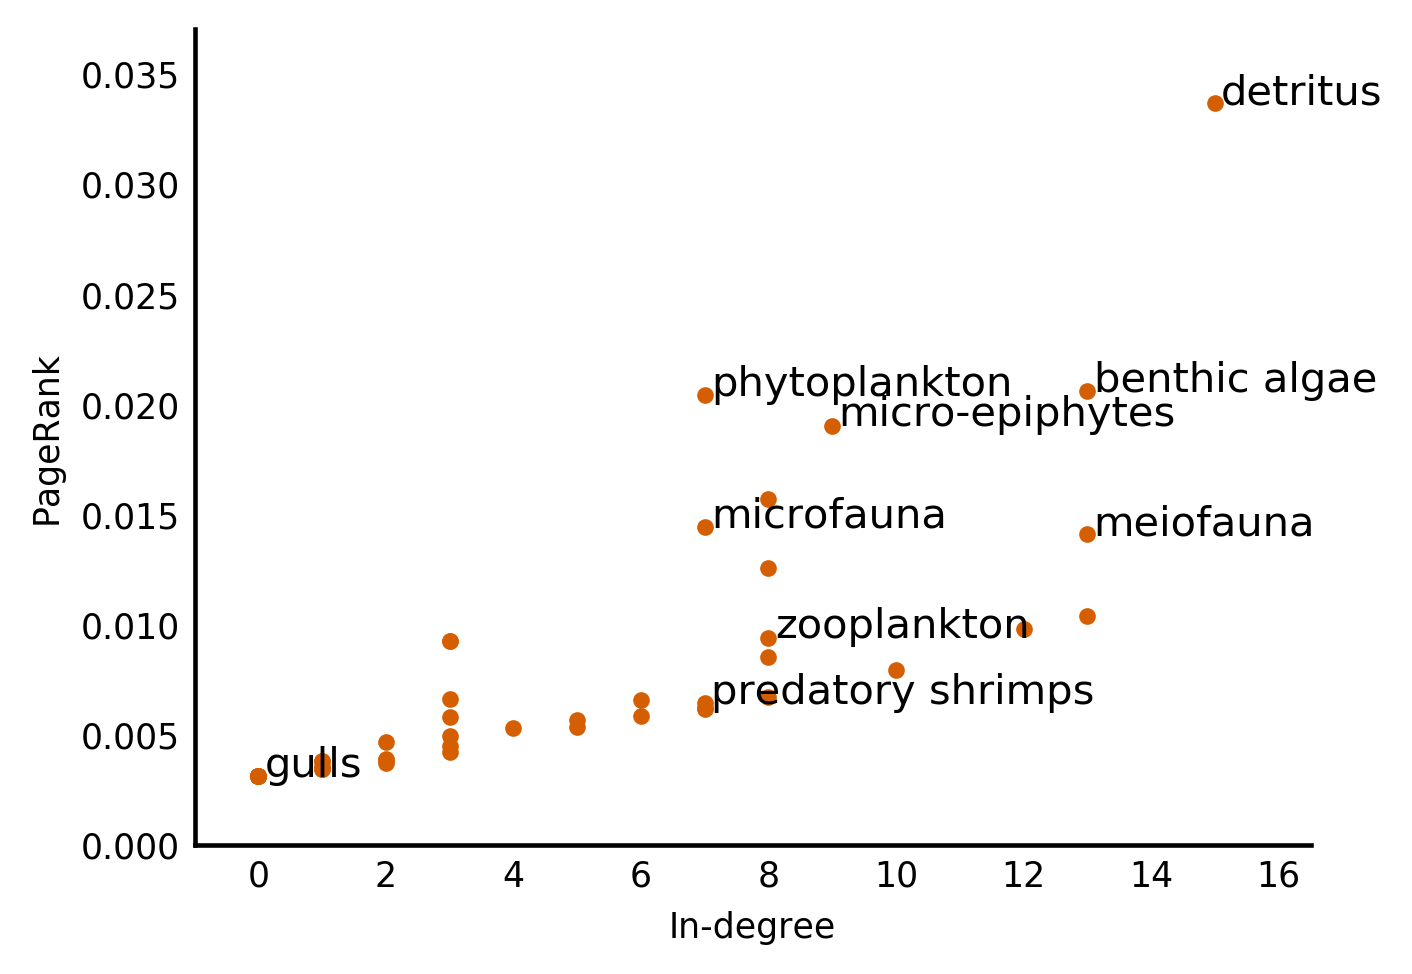

In [32]:
interesting = ['detritus', 'phytoplankton', 'benthic algae', 'micro-epiphytes',
               'microfauna', 'zooplankton', 'predatory shrimps', 'meiofauna',
               'gulls']
in_degrees = np.ravel(Adj.sum(axis=0))
pagerank_plot(in_degrees, pagerank, species, annotations=interesting)

In [33]:
def power(Trans, damping=0.85, max_iter=10**5):
    n = Trans.shape[0]
    r0 = np.full(n, 1/n)
    r = r0
    for _iter_num in range(max_iter):
        rnext = damping * Trans @ r + (1 - damping) / n
        if np.allclose(rnext, r):
            break
        r = rnext
    return r
